# Peaks To Gene Heatmaps + Gridmap

Creates a peak count heatmap per cluster, and a heatmap for linked genes, with selected genes and GO terms. Also plot gridmap of ATAC peaks.

Inputs:
1. `metadata.tsv` with UMAP/densMAP coordinates, day and cluster.
2. Config:
    - Colours for each day
    - For each cluster, colour, description, new cluster number (set to same as original if it should not be changed)
3. Single-cell counts matrix derived from snapATAC with corresponding peaks.
4. Set of bed files corresponding to peak sets which are a subset of peaks in the above matrix.
5. Seurat scRNA object
6. scRNA cells labels transferred from scATAC clusters
7. Peak -> Gene links
8. List of GO Terms in order, with p-value and group number.

In [2]:
library(Matrix)
library(ggplot2)
library(patchwork)
library(GenomicRanges)
library(scales)
library(DESeq2)
library(reshape2)
library(viridis)
library(ComplexHeatmap)
library(ggrastr)
library(Seurat)


Attaching package: ‘Seurat’


The following object is masked from ‘package:SummarizedExperiment’:

    Assays




In [3]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14")

### MetaData

In [4]:
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../../analysis/20200206_pmat_snapATAC/sessions/20200520_n68916/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
metaData$sample = factor(metaData$sample, levels=DAYS)
dim(metaData)
head(metaData, 5)

[1] 68916     5

barcode          sample umap1    umap2    
D0_AAACAACGACGATTAC AAACAACGACGATTAC D0     6.565758 -8.649868
D0_AAACAACGAGCGCACT AAACAACGAGCGCACT D0     5.604522 -7.835411
D0_AAACACGCTACGCCAC AAACACGCTACGCCAC D0     5.130516 -7.593246
D0_AAACACGCTAGTACGG AAACACGCTAGTACGG D0     4.926843 -8.365463
D0_AAACACGCTCCTCAAA AAACACGCTCCTCAAA D0     6.056337 -5.647577
                    cells              
D0_AAACAACGACGATTAC D0_AAACAACGACGATTAC
D0_AAACAACGAGCGCACT D0_AAACAACGAGCGCACT
D0_AAACACGCTACGCCAC D0_AAACACGCTACGCCAC
D0_AAACACGCTAGTACGG D0_AAACACGCTAGTACGG
D0_AAACACGCTCCTCAAA D0_AAACACGCTCCTCAAA

In [5]:
# this is a kludge for now, clusters should also be present in same metaData as above
snapATAC_metaData = read.table("../../analysis/20200122_snapATAC/snapATAC_sessions/20200518_n76052/metadata.tsv", header = T)
rownames(snapATAC_metaData) = paste(snapATAC_metaData$sample, snapATAC_metaData$barcode, sep='_')

metaData$cluster = snapATAC_metaData[rownames(metaData), "cluster"] 
head(metaData)

barcode          sample umap1    umap2    
D0_AAACAACGACGATTAC AAACAACGACGATTAC D0     6.565758 -8.649868
D0_AAACAACGAGCGCACT AAACAACGAGCGCACT D0     5.604522 -7.835411
D0_AAACACGCTACGCCAC AAACACGCTACGCCAC D0     5.130516 -7.593246
D0_AAACACGCTAGTACGG AAACACGCTAGTACGG D0     4.926843 -8.365463
D0_AAACACGCTCCTCAAA AAACACGCTCCTCAAA D0     6.056337 -5.647577
D0_AAACACGCTCGAGTGA AAACACGCTCGAGTGA D0     3.408866 -9.058377
                    cells               cluster
D0_AAACAACGACGATTAC D0_AAACAACGACGATTAC 5      
D0_AAACAACGAGCGCACT D0_AAACAACGAGCGCACT 5      
D0_AAACACGCTACGCCAC D0_AAACACGCTACGCCAC 5      
D0_AAACACGCTAGTACGG D0_AAACACGCTAGTACGG 6      
D0_AAACACGCTCCTCAAA D0_AAACACGCTCCTCAAA 5      
D0_AAACACGCTCGAGTGA D0_AAACACGCTCGAGTGA 6

### Day and Cluster Configs

In [6]:
day_config = read.table("../configs/day.tsv", comment.char = '', header=T)
day_config$colour = as.character(day_config$colour)
day_config$day = factor(day_config$day, levels=DAYS)
rownames(day_config) = day_config$day
day_config

day colour 
D0  D0  #A61C24
D2  D2  #FF70A6
D4  D4  #D6E82F
D6  D6  #B14AED
D8  D8  #2D3142
D10 D10 #FC7753
D12 D12 #0AABB7
D14 D14 #336699

In [7]:
cluster_config = read.table("../configs/cluster.tsv", comment.char = '', header=T, sep='\t')
cluster_config$colour = as.character(cluster_config$colour)
cluster_config$description = as.character(cluster_config$description)

rownames(cluster_config) = cluster_config$cluster
cluster_config

cluster colour  description            new_cluster
1   1      #F4D5CD Intermediate           12         
2   2      #78A824 Pre-iPSC               15         
3   3      #F01D35 Fibroblast-like         5         
4   4      #E85F6D Fibroblast-like         3         
5   5      #B03743 Fibroblast              1         
6   6      #7C2730 Fibroblast              2         
7   7      #CF175A Fibroblast-like         4         
8   8      #CCCCCC Doublets               17         
9   9      #F7A6C2 Keratinocyte-like       6         
10 10      #A6D854 Pre-iPSC               16         
11 11      #406614 Partially-reprogrammed 14         
12 12      #BD6A37 Intermediate           11         
13 13      #D4B81C Intermediate           10         
14 14      #F0520A Early intermediate      7         
15 15      #F0A118 Intermediate           13         
16 16      #2BB5A3 Neural-like             9         
17 17      #006658 Neural-like             8         
18 18      #9BE89E iPSC                   18

### Seurat Object

In [8]:
rna = readRDS("./sessions/20200913_n27632/seurat.rds")
rna$tech = "rna"

### ATAC-RNA Label Transfer

In [85]:
atac.rna.label = read.table("../../analysis/20200828_RNA_Seurat/sessions/20200913_n27632/atac.20200520_n68916.cluster.transfer.tsv",
                           header=T)
rownames(atac.rna.label) = atac.rna.label$barcode
atac.rna.label$barcode = NULL

all(rownames(atac.rna.label)==colnames(rna))

# transfer to new cluster
atac.rna.label$atac_new_cluster = cluster_config[atac.rna.label$atac_cluster, "new_cluster"]

head(atac.rna.label)

[1] TRUE

sample atac_cluster atac_new_cluster
AAACCCAAGAGTGACC-1 D0     5            1               
AAACCCAAGTGCCAGA-1 D0     5            1               
AAACCCACACCATTCC-1 D0     6            2               
AAACCCACACGCGTCA-1 D0     5            1               
AAACCCAGTCCATAGT-1 D0     6            2               
AAACCCAGTTATTCTC-1 D0     6            2

### Insertions Count Matrix + Regions

In [32]:
pmat = readMM("../../analysis/20200206_pmat_snapATAC/sessions/20200520_n68916/pmat.overlap.smallpeaks.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  68916 803958

In [9]:
peak_regions = read.table("../../analysis/20200206_pmat_snapATAC/sessions/20200520_n68916/peaks.overlap.smallpeaks.bed")
names(peak_regions) = c("chr", "bp1", "bp2")
peak_regions$site_name <- paste(peak_regions$chr, peak_regions$bp1, peak_regions$bp2, sep="_")
row.names(peak_regions) <- peak_regions$site_name
dim(peak_regions)
head(peak_regions)

[1] 803958      4

chr  bp1       bp2       site_name               
chr1_97145604_97145864   chr1  97145604  97145864 chr1_97145604_97145864  
chr1_7538148_7538363     chr1   7538148   7538363 chr1_7538148_7538363    
chr1_93196678_93196894   chr1  93196678  93196894 chr1_93196678_93196894  
chr1_187577713_187577913 chr1 187577713 187577913 chr1_187577713_187577913
chr1_53278065_53278265   chr1  53278065  53278265 chr1_53278065_53278265  
chr1_177176832_177177032 chr1 177176832 177177032 chr1_177176832_177177032

In [10]:
peak_regions_gr =  GRanges(sub("_", "-", sub("_", ":", rownames(peak_regions))))

In [11]:
# check if reads at OCT promoter (none in initial version)
sum(pmat[,subjectHits(findOverlaps(GRanges(c("chr6:31170549-31170836")), peak_regions_gr))])

[1] 537

In [12]:
pmatRowSums = Matrix::rowSums(pmat)

### Cluster Aggregated Matrix

### Peaks

In [13]:
# CAREFUL: reassigning clusters to their new cluster labels! 
# ensure cluster_config is in order
new_cluster_per_cell = cluster_config$new_cluster[metaData$cluster]

agg_matrix = sparseMatrix(i=new_cluster_per_cell,
                         j=seq(1,nrow(pmat)),
                         x=1L,
                         dims=c(length(table(new_cluster_per_cell)), nrow(pmat)))

In [14]:
cts = as.matrix(agg_matrix %*% pmat)
colnames(cts) = sub("_", "-", sub("_", ":", rownames(peak_regions)))
rownames(cts) = paste("cluster", seq(1,nrow(cts)), sep="_")
cts = t(cts)
head(cts)
dim(cts)

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5
chr1:97145604-97145864   103       145        74       141       34       
chr1:7538148-7538363     193       233       151       314       19       
chr1:93196678-93196894    82        67        12        23        2       
chr1:187577713-187577913  47        31        27         7        0       
chr1:53278065-53278265    51        26        40        58        3       
chr1:177176832-177177032  10         4         3        11        3       
                         cluster_6 cluster_7 cluster_8 cluster_9 cluster_10
chr1:97145604-97145864   43        24        30         14       73        
chr1:7538148-7538363     78        29        34         14       96        
chr1:93196678-93196894    5         1        18          1       12        
chr1:187577713-187577913  1         1         5         11       29        
chr1:53278065-53278265   24        16        12         12       37        
chr1:177176832-177177032  0        12        59        118       45        
                         cluster_11 cluster_12 cluster_13 cluster_14 cluster_15
chr1:97145604-97145864   79         74         20         33          8        
chr1:7538148-7538363     55         62         73         12         39        
chr1:93196678-93196894    1         10          4          0          3        
chr1:187577713-187577913 10         22         14          0          4        
chr1:53278065-53278265   25         47         35          5         11        
chr1:177176832-177177032  6         73         21          0          4        
                         cluster_16 cluster_17 cluster_18
chr1:97145604-97145864   8          38         0         
chr1:7538148-7538363     8          40         0         
chr1:93196678-93196894   1           6         0         
chr1:187577713-187577913 0           6         0         
chr1:53278065-53278265   5          12         0         
chr1:177176832-177177032 2           5         0

[1] 803958     18

In [16]:
# removing cluster_18 (iPSC) for now since it has very few cells
cts = cts[,1:17]

In [17]:
sum(rowSums(cts<10)==0)

[1] 157610

In [18]:
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts[rowSums(cts<10)==0, ]))

In [19]:
# bin length normalized
binnorm_log_cts = log2(1+200*(norm_cts/width(GRanges(rownames(norm_cts)))))

In [20]:
head(binnorm_log_cts)

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5
chr1:97145604-97145864   5.246563  6.103949  5.142254  5.762659  6.605542 
chr1:7538148-7538363     6.404163  7.051036  6.419734  7.173951  6.046133 
chr1:93196678-93196894   5.185653  5.273154  2.943568  3.517980  2.966969 
chr1:187577713-187577913 4.517405  4.308664  4.109216  2.149078  0.000000 
chr1:53278065-53278265   4.630292  4.068840  4.648829  4.880935  3.590072 
chr1:177176832-177177032 2.500805  1.777365  1.488759  2.677745  3.590072 
                         cluster_6 cluster_7 cluster_8 cluster_9 cluster_10
chr1:97145604-97145864   5.175388  4.979347  4.772335  4.099198  5.031476  
chr1:7538148-7538363     6.285670  5.510901  5.211614  4.357630  5.683187  
chr1:93196678-93196894   2.564153  1.339581  4.321943  1.254907  2.861700  
chr1:187577713-187577913 1.043379  1.407424  2.743722  4.126457  4.117305  
chr1:53278065-53278265   4.726024  4.778318  3.875300  4.245088  4.450691  
chr1:177176832-177177032 0.000000  4.380699  6.092460  7.472753  4.721314  
                         cluster_11 cluster_12 cluster_13 cluster_14 cluster_15
chr1:97145604-97145864   6.0159274  4.647093   3.466929   5.804131   2.796274  
chr1:7538148-7538363     5.7707261  4.664150   5.503252   4.650290   5.171057  
chr1:93196678-93196894   0.9781839  2.295719   1.773708   0.000000   1.880515  
chr1:187577713-187577913 3.5200407  3.362709   3.342221   0.000000   2.281179  
chr1:53278065-53278265   4.7644690  4.381268   4.576167   3.560263   3.538173  
chr1:177176832-177177032 2.8645684  4.991634   3.878968   0.000000   2.281179  
                         cluster_16 cluster_17
chr1:97145604-97145864   3.973818   5.061117  
chr1:7538148-7538363     4.230918   5.398868  
chr1:93196678-93196894   1.683437   2.837983  
chr1:187577713-187577913 0.000000   2.933528  
chr1:53278065-53278265   3.693763   3.835877  
chr1:177176832-177177032 2.530069   2.707776

### Genes

In [87]:
dim(pmat)

[1]  68916 803958

In [90]:
ncol(rna@assays$RNA@counts)

[1] 59369

In [96]:
# CAREFUL: reassigning clusters to their new cluster labels! 
# ensure cluster_config is in order
new_cluster_per_cell = cluster_config$new_cluster[metaData$cluster]

rna_agg_matrix = sparseMatrix(i=atac.rna.label$atac_new_cluster,
                         j=seq(1,ncol(rna@assays$RNA@counts)),
                         x=1L,
                         dims=c(length(table(atac.rna.label$atac_new_cluster)), ncol(rna@assays$RNA@counts)))

In [102]:
sort(colSums(rna_cts))

cluster_8 cluster_17 cluster_10 cluster_11  cluster_5  cluster_7 cluster_13 
    553082     814452    6649188   22749483   25641729   26681308   42920006 
 cluster_6  cluster_3  cluster_9 cluster_14  cluster_2 cluster_16  cluster_1 
  46203460   46462259   47439506   47474418   60687980   61237048   71329934 
cluster_15  cluster_4 cluster_12 
  84714830  106157153  132581666

In [98]:
rna_cts = as.matrix(rna_agg_matrix %*% t(rna@assays$RNA@counts))
colnames(rna_cts) = rownames(rna)
rownames(rna_cts) = paste("cluster", seq(1,nrow(rna_cts)), sep="_")
rna_cts = t(rna_cts)
head(rna_cts)
dim(rna_cts)

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5 cluster_6
AL627309.1  10         6         3          6        1         2      
AL627309.5  43        18        29         44       19        27      
AP006222.2   1         0         1          1        0         0      
LINC01409  123       119        88        191       69        76      
FAM87B       3         5         7         20        4        17      
LINC01128  402       451       448       1121      189       554      
           cluster_7 cluster_8 cluster_9 cluster_10 cluster_11 cluster_12
AL627309.1   2        0          1        0           0          19      
AL627309.5   7        0         22        1           9          66      
AP006222.2   0        0          0        0           0           1      
LINC01409   51        0        110       26          74         463      
FAM87B       6        0         12        1          10          19      
LINC01128  358       11        565       77         208        1385      
           cluster_13 cluster_14 cluster_15 cluster_16 cluster_17
AL627309.1  16          3         27          6         0        
AL627309.5  36         42         98         73         0        
AP006222.2   0          1          0          1         0        
LINC01409  138        105        295        166         1        
FAM87B       4          5          5          2         0        
LINC01128  346        343        555        397        11

[1] 27632    17

In [103]:
# removing cluster_18 (iPSC) for now since it has very few cells
rna_cts = rna_cts[,1:17]

In [106]:
sum(rowSums(rna_cts<10)==0)

[1] 5822

In [111]:
rna_cts = rna_cts[rowSums(rna_cts)>20,]
dim(rna_cts)

[1] 22381    17

In [114]:
rna_norm_cts = t(t(rna_cts)/estimateSizeFactorsForMatrix(rna_cts))

In [115]:
# bin length normalized
rna_log_cts = log2(1+(rna_norm_cts))
rna_log_znorm_cts = t(scale(t(rna_log_cts)))

In [116]:
head(rna_log_znorm_cts)

cluster_1   cluster_2   cluster_3   cluster_4   cluster_5 
AL627309.1  0.84367630  0.41017913 -0.02378109 -0.09879184 -0.3262372
AL627309.5  0.46174282 -0.23373045  0.35802202  0.02992307  0.6009112
LINC01409  -0.00233915  0.03896260 -0.05390277 -0.06557011  0.3583566
FAM87B     -0.81041145 -0.30422050  0.24692926  0.54130752  0.3936882
LINC01128  -1.60448601 -0.93102257 -0.25481950  0.19747110 -0.8521360
LINC00115  -0.18689698 -0.04404998  0.10238160  0.28433381  0.5695601
           cluster_6    cluster_7   cluster_8 cluster_9  cluster_10
AL627309.1 -0.278767194  0.18781180 -1.281867 -0.6897044 -1.2818666
AL627309.5  0.354601313 -0.30824278 -2.321723  0.1662975 -0.7517587
LINC01409  -0.126102231  0.04695017 -3.679173  0.2066260  0.7125644
FAM87B      1.378079926  0.82181840 -1.916776  0.9399227  0.3634537
LINC01128   0.723450019  1.25250477  1.951198  0.7682264  0.7592382
LINC00115  -0.006168666 -0.12593121 -3.635857  0.1132725  0.9858588
           cluster_11   cluster_12  cluster_13  cluster_14  cluster_15
AL627309.1 -1.281866636  0.82315216  1.94274720  0.01211561  1.7485549
AL627309.5  0.002767858  0.25303393  0.75536332  0.73345891  1.0451900
LINC01409   0.493230283  0.60931370  0.56458223  0.14846831  0.6321339
FAM87B      1.593080985  0.31141708 -0.10851652 -0.06275470 -0.5451329
LINC01128  -0.251832808  0.40432884 -0.38127556 -1.03315449 -1.1285629
LINC00115   0.491772527 -0.05785407  0.06485226  0.36315320 -0.2427792
           cluster_16 cluster_17
AL627309.1  0.5765112 -1.2818666
AL627309.5  1.1758652 -2.3217226
LINC01409   0.5031143 -0.3872150
FAM87B     -0.9251088 -1.9167765
LINC01128  -0.7783143  1.1591869
LINC00115   0.7333380  0.5910148

### Peak Sets

In [21]:
BASE_PATH = "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40/"
list.files(BASE_PATH)

[1] "all_peaks.bed" "idx1.bed"      "idx10.bed"     "idx11.bed"    
 [5] "idx12.bed"     "idx13.bed"     "idx14.bed"     "idx15.bed"    
 [9] "idx16.bed"     "idx17.bed"     "idx18.bed"     "idx19.bed"    
[13] "idx2.bed"      "idx20.bed"     "idx21.bed"     "idx22.bed"    
[17] "idx23.bed"     "idx24.bed"     "idx25.bed"     "idx26.bed"    
[21] "idx27.bed"     "idx28.bed"     "idx29.bed"     "idx3.bed"     
[25] "idx30.bed"     "idx31.bed"     "idx32.bed"     "idx33.bed"    
[29] "idx34.bed"     "idx35.bed"     "idx36.bed"     "idx37.bed"    
[33] "idx38.bed"     "idx39.bed"     "idx4.bed"      "idx40.bed"    
[37] "idx5.bed"      "idx6.bed"      "idx7.bed"      "idx8.bed"     
[41] "idx9.bed"      "README.md"     "width_200bp"

In [22]:
PEAK_SET_BEDS = list.files(BASE_PATH, 
                           full.names=T,
                          pattern="*idx[0-9]+.bed")
PEAK_SET_NAMES = sub(".bed", "", list.files(BASE_PATH, 
                          pattern="*idx[0-9]+.bed"))
length(PEAK_SET_BEDS)
length(PEAK_SET_NAMES)

[1] 40

[1] 40

In [23]:
PEAK_SET_BEDS
PEAK_SET_NAMES

[1] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx1.bed" 
 [2] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx10.bed"
 [3] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx11.bed"
 [4] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx12.bed"
 [5] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx13.bed"
 [6] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx14.bed"
 [7] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx15.bed"
 [8] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx16.bed"
 [9] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx17.bed"
[10] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx18.bed"
[11] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx19.bed"
[12] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx2.bed" 
[13] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx20.bed"
[14] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx21.bed"
[15] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx22.bed"
[16] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx23.bed"
[17] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx24.bed"
[18] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx25.bed"
[19] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx26.bed"
[20] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx27.bed"
[21] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx28.bed"
[22] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx29.bed"
[23] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx3.bed" 
[24] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx30.bed"
[25] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx31.bed"
[26] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx32.bed"
[27] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx33.bed"
[28] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx34.bed"
[29] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx35.bed"
[30] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx36.bed"
[31] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx37.bed"
[32] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx38.bed"
[33] "../../analysis/20200307_fin

[1] "idx1"  "idx10" "idx11" "idx12" "idx13" "idx14" "idx15" "idx16" "idx17"
[10] "idx18" "idx19" "idx2"  "idx20" "idx21" "idx22" "idx23" "idx24" "idx25"
[19] "idx26" "idx27" "idx28" "idx29" "idx3"  "idx30" "idx31" "idx32" "idx33"
[28] "idx34" "idx35" "idx36" "idx37" "idx38" "idx39" "idx4"  "idx40" "idx5" 
[37] "idx6"  "idx7"  "idx8"  "idx9"

---
Assign peak set indices to peaks and remove peaks that aren't in any peak set.

In [24]:
peak_to_row_idx = rep(-1, nrow(binnorm_log_cts))

# assign peak set indices to peaks
for (i in seq(length(PEAK_SET_NAMES))) {
    cur_peaks = read.table(PEAK_SET_BEDS[[i]])
    peak_to_row_idx[rownames(binnorm_log_cts) %in% paste(paste(cur_peaks$V1, cur_peaks$V2, sep=':'), cur_peaks$V3, sep='-')] = PEAK_SET_NAMES[[i]]
}

In [25]:
sum(peak_to_row_idx== -1)

[1] 40791

In [26]:
binnorm_log_cts = binnorm_log_cts[peak_to_row_idx != -1, ]
dim(binnorm_log_cts)

[1] 763167     17

In [27]:
peak_to_row_idx = peak_to_row_idx[peak_to_row_idx != -1]

In [28]:
head(peak_to_row_idx)

[1] "idx6"  "idx9"  "idx2"  "idx2"  "idx12" "idx15"

### Peak-> Gene Links

In [161]:
p2g_df = read.table("../../analysis/20200925_Peak2Gene/peak2gene_links/20200913_n27632/20200925_cor0.45.tsv", 
                    sep='\t',
                   header=T)
dim(p2g_df)
head(p2g_df)

[1] 149490      6

peak               gene      Correlation FDR          VarQATAC  VarQRNA  
1 chr1:998870-999115 LINC01128 0.5143508   1.379834e-33 0.9430070 0.4471862
2 chr1:817304-817603 LINC02593 0.4784177   1.422211e-28 0.9986056 0.3615493
3 chr1:923745-924044 LINC02593 0.4505192   4.453938e-25 0.9220954 0.3615493
4 chr1:943173-943379 LINC02593 0.4645768   8.473222e-27 0.8292050 0.3615493
5 chr1:817304-817603 SAMD11    0.7163478   2.897274e-77 0.9986056 0.7551148
6 chr1:817692-817947 SAMD11    0.6097022   2.890740e-50 0.8978268 0.7551148

In [162]:
# remove genes with low counts
p2g_df = p2g_df[p2g_df$gene %in% rownames(rna_log_znorm_cts), ]
dim(p2g_df)

[1] 147171      6

In [163]:
# need to subtract 1 to start of peak for some reason
p2g_gr = GRanges(p2g_df$peak)
start(p2g_gr) = start(p2g_gr) - 1 
p2g_df$peak = as.character(p2g_gr)

## Plotting

### Full Peak Heatmap

In [34]:
## use this to filter by peak sets if required
PEAK_SETS_TO_EXCLUDE = c()
include_peak_set = !(peak_to_row_idx %in% PEAK_SETS_TO_EXCLUDE)

matrix_to_plot = binnorm_log_cts[include_peak_set, 1:16]
assigned_peak_idx = peak_to_row_idx[include_peak_set]

In [210]:
head(peak_to_row_idx)

[1] "idx6"  "idx9"  "idx2"  "idx2"  "idx12" "idx15"

In [212]:
assigned_peak_idx_df = data.frame(assigned_peak_idx)
rownames(assigned_peak_idx_df) = rownames(matrix_to_plot)
dim(assigned_peak_idx_df)
head(assigned_peak_idx_df)

[1] 763167      1

assigned_peak_idx
chr1:97145604-97145864   idx6             
chr1:7538148-7538363     idx9             
chr1:93196678-93196894   idx2             
chr1:187577713-187577913 idx2             
chr1:53278065-53278265   idx12            
chr1:177176832-177177032 idx15

In [35]:
dim(matrix_to_plot)
length(assigned_peak_idx)

[1] 763167     16

[1] 763167

In [36]:
# compute median for each peak set to figure out order
median_matrix = aggregate(matrix_to_plot, list(assigned_peak_idx), median)
rownames(median_matrix) = median_matrix$Group.1
median_matrix$Group.1 = NULL
dim(median_matrix)
head(median_matrix)

[1] 40 16

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5 cluster_6 cluster_7
idx1  4.106792  4.080139  4.149764  4.259932  3.590072  4.055509  4.380699 
idx10 5.699175  5.828247  6.047475  6.439919  5.975931  6.428662  6.817125 
idx11 2.643146  2.549913  3.142096  3.368038  3.063799  5.368764  3.651730 
idx12 3.736010  3.769808  4.224160  4.623255  4.167445  5.543035  4.752291 
idx13 3.921628  3.851193  4.783794  4.729032  5.374672  4.143679  3.664273 
idx14 3.079979  2.940540  4.341207  4.019177  5.240642  3.246164  2.574802 
      cluster_8 cluster_9 cluster_10 cluster_11 cluster_12 cluster_13
idx1  5.315545  4.781818  4.244015   3.869235   3.971314   3.671965  
idx10 6.801137  6.936719  6.668476   6.747316   6.895767   6.427965  
idx11 4.427115  3.520825  3.652631   3.229215   3.561922   3.597004  
idx12 4.989548  4.640979  4.690135   4.509345   4.764029   4.653064  
idx13 4.083579  3.855191  4.455209   4.523005   4.197428   4.234955  
idx14 3.159897  2.750808  3.572880   3.096108   2.874176   3.143344  
      cluster_14 cluster_15 cluster_16
idx1  2.902610   2.615375   2.361156  
idx10 6.018483   5.361427   4.558482  
idx11 2.902610   3.124576   3.287899  
idx12 3.900736   3.911545   3.762995  
idx13 4.750131   3.826259   3.475904  
idx14 3.268590   2.745444   2.530069

In [37]:
# default order
peak_set_order = rownames(median_matrix)[order(nchar(rownames(median_matrix)), rownames(median_matrix))]

# order peak sets -- using a heurestic here to get diagonal structure
# peak_set_order = rownames(median_matrix)[order(rowSums(t(seq(1,ncol(median_matrix))*t(2**(median_matrix)-1)))/rowSums(2**(median_matrix)-1))]
# peak_set_order = rownames(median_matrix)[order(rowSums(t(seq(1,ncol(median_matrix))*t(median_matrix)))/rowSums(median_matrix))]
# peak_set_order = rownames(median_matrix)[order(rowSums(t(seq(1,ncol(median_matrix))*(scale(t(median_matrix))))))]
peak_set_order

[1] "idx1"  "idx2"  "idx3"  "idx4"  "idx5"  "idx6"  "idx7"  "idx8"  "idx9" 
[10] "idx10" "idx11" "idx12" "idx13" "idx14" "idx15" "idx16" "idx17" "idx18"
[19] "idx19" "idx20" "idx21" "idx22" "idx23" "idx24" "idx25" "idx26" "idx27"
[28] "idx28" "idx29" "idx30" "idx31" "idx32" "idx33" "idx34" "idx35" "idx36"
[37] "idx37" "idx38" "idx39" "idx40"

In [38]:
melted_median_matrix = melt(as.matrix(median_matrix))
melted_median_matrix$Var1 = factor(melted_median_matrix$Var1, levels = rev(peak_set_order))
melted_median_matrix$Var2 = factor(melted_median_matrix$Var2, levels = colnames(median_matrix))
head(melted_median_matrix, 2)

Var1  Var2      value   
1 idx1  cluster_1 4.106792
2 idx10 cluster_1 5.699175

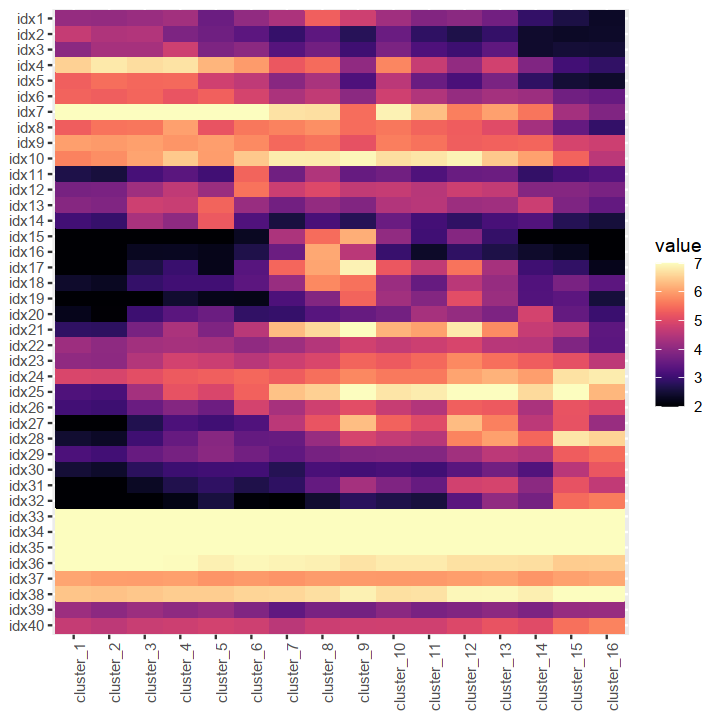

In [39]:
options(repr.plot.width = 6, repr.plot.height = 6)

# trial with peak set median accessibility
ggplot(data = melted_median_matrix, 
       aes(x = Var2, y = Var1, fill = value)) +
geom_tile()  + ylab(NULL) + xlab(NULL) +  
geom_raster(aes(fill=value)) +
scale_fill_viridis(limits=c(2, 7), oob=squish, option = "A") +
theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [40]:
dim(matrix_to_plot)

[1] 763167     16

In [129]:
old_to_new_peak_set_idx_map = list()
for (i in seq(length(peak_set_order))) {
    old_to_new_peak_set_idx_map[[peak_set_order[i]]] = as.character(i)
}

In [41]:
SUBSAMPLE = 50

In [43]:
matrix_to_plot_ordered = matrix_to_plot[order(factor(assigned_peak_idx,
                                                    levels=peak_set_order)), ]

# map to new order of peaks. This is used to facet, which automatically arranges in new peak order (1..num_peak_sets)
peak_assignments = unlist(old_to_new_peak_set_idx_map[as.character(sort(factor(assigned_peak_idx,levels=peak_set_order)))])

matrix_to_plot_ordered = matrix_to_plot_ordered[seq(1, nrow(matrix_to_plot_ordered), SUBSAMPLE), ]
peak_assignments = peak_assignments[seq(1, length(peak_assignments), SUBSAMPLE)]

dim(matrix_to_plot_ordered)
length(peak_assignments)

[1] 15264    16

[1] 15264

In [36]:
melted_matrix_to_plot = melt(as.matrix(matrix_to_plot_ordered))
melted_matrix_to_plot$Var1 = factor(melted_matrix_to_plot$Var1, levels = rownames(matrix_to_plot_ordered))
melted_matrix_to_plot$Var2 = factor(melted_matrix_to_plot$Var2, levels = colnames(matrix_to_plot_ordered))
head(melted_matrix_to_plot, 2)

Var1                     Var2      value   
1 chr1:180207952-180208152 cluster_1 5.376502
2 chr1:230857457-230857726 cluster_1 5.040713

In [176]:
cluster_config_colourbar_df = cluster_config
cluster_config_colourbar_df$text = paste(cluster_config_colourbar_df$new_cluster, 
                                         cluster_config_colourbar_df$description,
                                        sep =' - ')
cluster_config_colourbar_df = cluster_config_colourbar_df[order(cluster_config_colourbar_df$new_cluster), ]

# choose clusters properly
# Removing those not selected currently
cluster_config_colourbar_df = cluster_config_colourbar_df[1:16, ]
cluster_config_colourbar_df$text = factor(cluster_config_colourbar_df$text, 
                                         levels=cluster_config_colourbar_df$text)


cluster_colourbar <- ggplot(cluster_config_colourbar_df, aes(x=as.factor(text), 
                                                y=1, 
                                                fill = as.factor(text), 
                                                label=as.factor(text))) +
  geom_bar(stat="identity") +
#   xlab("Cluster") +
  theme_void() +
  scale_fill_manual(values = cluster_config_colourbar_df$colour) +
  theme(legend.position = 'none',
        axis.text.x = element_text(size=12, angle=90, hjust=1),
        axis.title.x = element_blank()) #element_text(size=16))

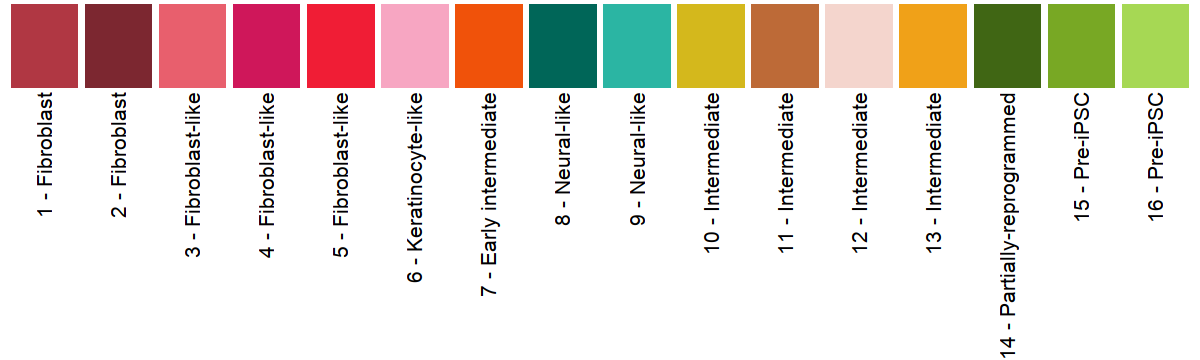

In [307]:
options(repr.plot.width = 10, repr.plot.height = 3)

cluster_colourbar

In [538]:
heatmap <- ggplot(data = melted_matrix_to_plot, 
       aes(x = Var2, y = Var1, fill = value)) +
geom_tile()  + ylab(NULL) + xlab(NULL) +  
geom_raster(aes(fill=value)) +
facet_grid(as.integer(peak_assignments) ~ ., switch = "y", scales = "free_y", space = "free_y")+
scale_fill_viridis(limits=c(2, 7), oob=squish, option = "A", name="Log2\nInsertions ") +
theme_minimal() +
theme(axis.text.x = element_blank() , # element_text(angle = 90, hjust = 1),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        axis.ticks.x=element_blank(),     
        strip.background = element_blank(),      
        strip.text.y.left = element_text(angle = 0, size=7),
        panel.spacing = unit(0.15, "lines"))

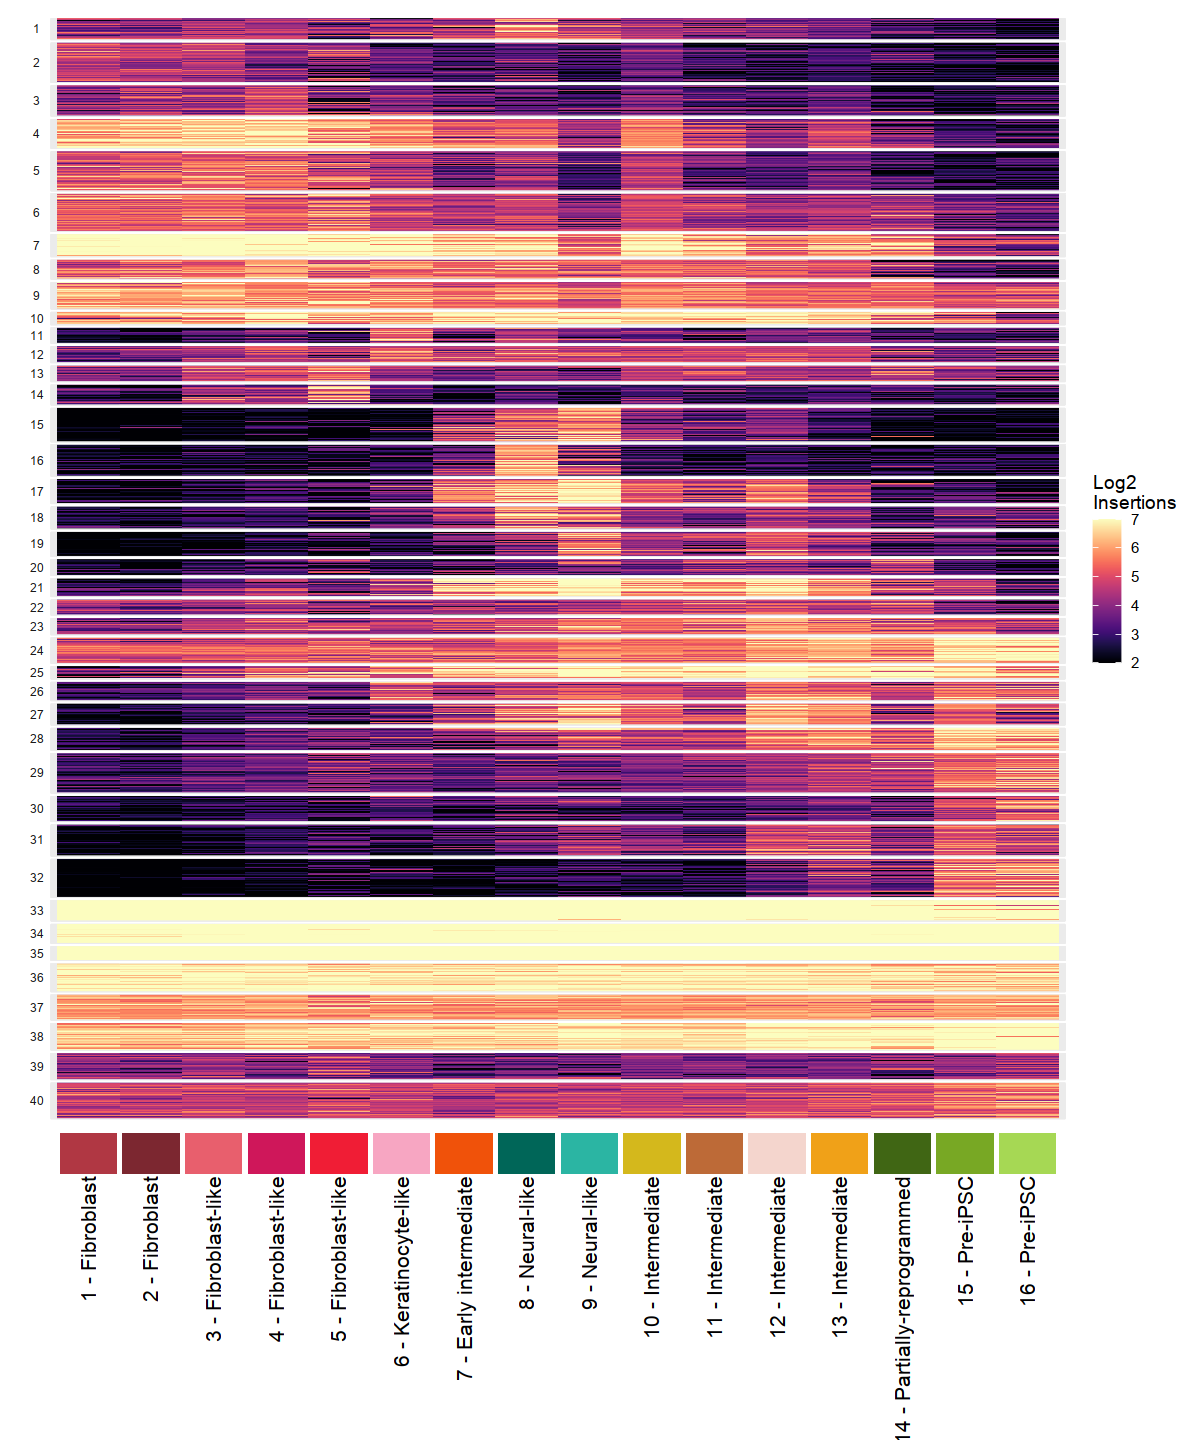

In [85]:
options(repr.plot.width = 10, repr.plot.height = 12)

cluster_by_day_with_colourbar = wrap_plots(heatmap, cluster_colourbar, nrow=2, heights=c(10,0.4))
cluster_by_day_with_colourbar

In [40]:
old_to_new_peak_set_idx_map

$idx1
[1] "1"

$idx2
[1] "2"

$idx3
[1] "3"

$idx4
[1] "4"

$idx5
[1] "5"

$idx6
[1] "6"

$idx7
[1] "7"

$idx8
[1] "8"

$idx9
[1] "9"

$idx10
[1] "10"

$idx11
[1] "11"

$idx12
[1] "12"

$idx13
[1] "13"

$idx14
[1] "14"

$idx15
[1] "15"

$idx16
[1] "16"

$idx17
[1] "17"

$idx18
[1] "18"

$idx19
[1] "19"

$idx20
[1] "20"

$idx21
[1] "21"

$idx22
[1] "22"

$idx23
[1] "23"

$idx24
[1] "24"

$idx25
[1] "25"

$idx26
[1] "26"

$idx27
[1] "27"

$idx28
[1] "28"

$idx29
[1] "29"

$idx30
[1] "30"

$idx31
[1] "31"

$idx32
[1] "32"

$idx33
[1] "33"

$idx34
[1] "34"

$idx35
[1] "35"

$idx36
[1] "36"

$idx37
[1] "37"

$idx38
[1] "38"

$idx39
[1] "39"

$idx40
[1] "40"

In [93]:
saveRDS(cluster_by_day_with_colourbar, file=sprintf("./subfigs/%s_peak_set_heatmap.rds",
                                format(Sys.Date(), "%Y%m%d")))
# required for building plot
saveRDS(peak_assignments, file=sprintf("./subfigs/%s_peak_set_heatmap_peak_assignments.rds",
                                format(Sys.Date(), "%Y%m%d")))

### Peak->Gene Heatmaps

In [ ]:
# !reusing variables from previous section

In [130]:
dim(matrix_to_plot)

[1] 763167     16

In [167]:
length(assigned_peak_idx)

[1] 763167

In [206]:
p2g_to_plot = p2g_df
p2g_to_plot = p2g_to_plot[p2g_to_plot$peak %in% rownames(matrix_to_plot), ]
p2g_to_plot$peak = factor(p2g_to_plot$peak, levels = rownames(matrix_to_plot)[rownames(matrix_to_plot) %in% unique(p2g_df$peak)])
p2g_to_plot = p2g_to_plot[order(p2g_to_plot$peak), ]

head(p2g_to_plot)

peak                     gene    Correlation FDR          VarQATAC 
10608 chr1:177176832-177177032 BRINP2  0.7563676   6.485684e-91 0.4571769
7303  chr1:109006296-109006522 SPATA42 0.4503177   4.708074e-25 0.3980556
7316  chr1:109006296-109006522 TAF13   0.5366612   5.129345e-37 0.3980556
7104  chr1:99867301-99867543   AGL     0.5428191   5.217923e-38 0.6376303
6361  chr1:81265383-81265677   ADGRL2  0.5360357   6.454713e-37 0.7288341
5225  chr1:55143773-55144021   PCSK9   0.5683195   2.377842e-42 0.8662517
      VarQRNA  
10608 0.5140299
7303  0.2335884
7316  0.9235775
7104  0.9815191
6361  0.7775522
5225  0.9487740

In [208]:
matrix_to_plot_with_link = matrix_to_plot[as.character(p2g_to_plot$peak), ]
dim(matrix_to_plot_with_link)

[1] 145423     16

In [213]:
assigned_peak_idx_with_link = assigned_peak_idx_df[as.character(p2g_to_plot$peak), 1]
length(assigned_peak_idx_with_link)

[1] 145423

In [759]:
matrix_to_plot_with_link_ordered = matrix_to_plot_with_link[order(factor(assigned_peak_idx_with_link,
                                                    levels=peak_set_order)), ]

# map to new order of peaks. This is used to facet, which automatically arranges in new peak order (1..num_peak_sets)
peak_assignments_with_link = unlist(old_to_new_peak_set_idx_map[as.character(sort(factor(assigned_peak_idx_with_link,levels=peak_set_order)))])

dim(matrix_to_plot_with_link_ordered)
length(peak_assignments_with_link)

[1] 145423     16

[1] 145423

In [772]:
melted_matrix_to_plot = melt(as.matrix(matrix_to_plot_with_link_ordered))
melted_matrix_to_plot$Var1 = factor(melted_matrix_to_plot$Var1, levels = unique(rownames(matrix_to_plot_with_link_ordered)))
melted_matrix_to_plot$Var2 = factor(melted_matrix_to_plot$Var2, levels = unique(colnames(matrix_to_plot_with_link_ordered)))
head(melted_matrix_to_plot, 2)

Var1                     Var2      value   
1 chr1:219811282-219811496 cluster_1 2.638742
2 chr1:31734609-31734825   cluster_1 4.156560

In [773]:
heatmap_peaks <- ggplot(data = melted_matrix_to_plot, 
       aes(x = Var2, y = Var1, fill = value)) +
geom_raster(aes(fill=value)) + ylab(NULL) + xlab(NULL) +  
facet_grid(as.integer(peak_assignments_with_link) ~ ., switch = "y", scales = "free_y", space = "free_y")+
scale_fill_viridis(limits=c(2, 7), oob=squish, option = "A", name="Log2 Insertions") +
theme_minimal() +
theme(axis.text.x = element_blank() , # element_text(angle = 90, hjust = 1),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        axis.ticks.x=element_blank(),     
        strip.background = element_blank(),      
        strip.text.y.left = element_text(angle = 0, size=7),
        panel.spacing = unit(0.15, "lines"),
     legend.position="none")

In [774]:
heatmap_peaks_legend <- cowplot::get_legend(ggplot(data = melted_matrix_to_plot[1:10,], 
       aes(x = Var2, y = Var1, fill = value)) +
geom_tile() +
scale_fill_viridis(limits=c(2, 7), oob=squish, option = "A", name="Log2 Insertions ") +
theme(legend.position="bottom"))

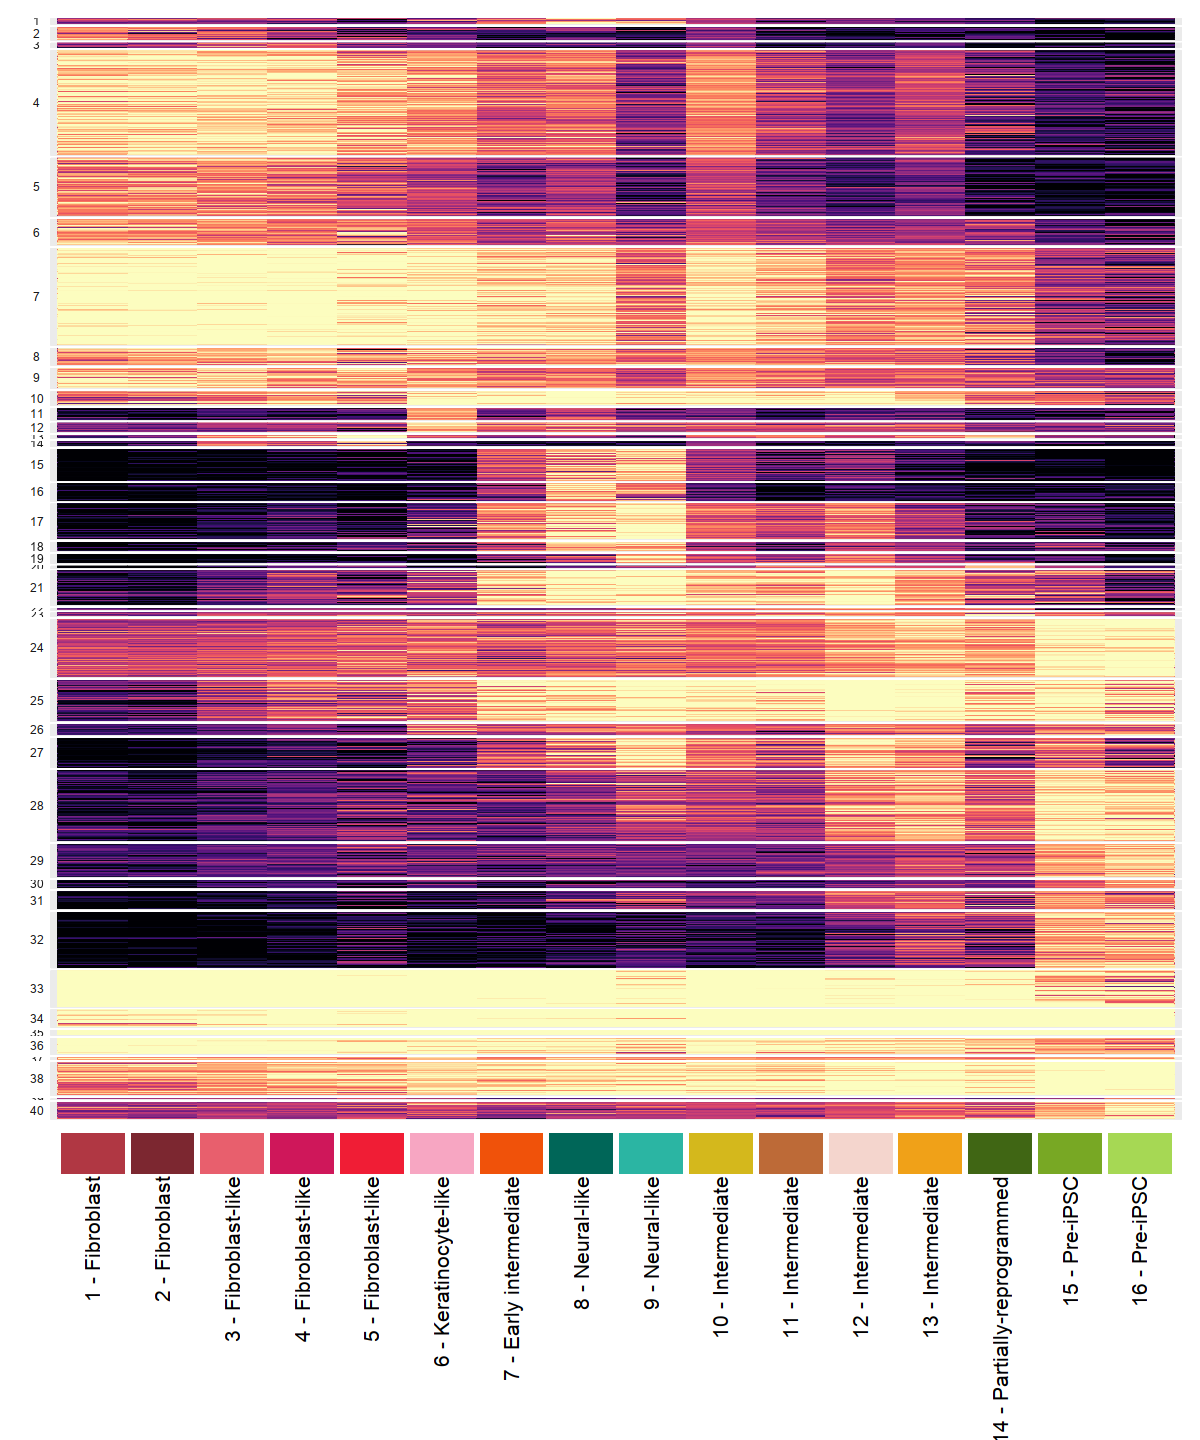

In [293]:
options(repr.plot.width = 10, repr.plot.height = 12)

p2g_heatmap_peak_with_colorbar = wrap_plots(heatmap_peaks, cluster_colourbar, nrow=2, heights=c(10,0.4))
p2g_heatmap_peak_with_colorbar

Now plotting the genes.

In [227]:
all(p2g_to_plot$gene %in% rownames(rna_log_znorm_cts))

[1] TRUE

In [247]:
rna_matrix_to_plot_with_link_ordered = rna_log_znorm_cts[as.character(p2g_to_plot$gene), 1:16][order(factor(assigned_peak_idx_with_link,
                                                   levels=peak_set_order)), ]

dim(rna_matrix_to_plot_with_link_ordered)

[1] 145423     16

In [274]:
# if original rownames are kept, it messes up order, most likely since same gene can appear in mulitple groups
rownames(rna_matrix_to_plot_with_link_ordered) = rownames(matrix_to_plot_with_link_ordered)

In [780]:
melted_matrix_to_plot = melt(as.matrix(rna_matrix_to_plot_with_link_ordered))
melted_matrix_to_plot$Var1 = factor(melted_matrix_to_plot$Var1, levels = unique(rownames(rna_matrix_to_plot_with_link_ordered)))
melted_matrix_to_plot$Var2 = factor(melted_matrix_to_plot$Var2, levels = unique(colnames(rna_matrix_to_plot_with_link_ordered)))
head(melted_matrix_to_plot, 2)

Var1                     Var2      value     
1 chr1:219811282-219811496 cluster_1 0.04292092
2 chr1:31734609-31734825   cluster_1 0.64861542

In [781]:
heatmap_rna <- ggplot(data = melted_matrix_to_plot, 
       aes(x = Var2, y = Var1, fill = value)) +
geom_raster(aes(fill=value)) + ylab(NULL) + xlab(NULL) +  
facet_grid(as.integer(peak_assignments_with_link) ~ ., switch = "y", scales = "free_y", space = "free_y")+
scale_fill_viridis(limits=c(-2, 2), oob=squish, option = "C", name="RNA Z-score") +
theme_minimal() +
theme(axis.text.x = element_blank() , # element_text(angle = 90, hjust = 1),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        axis.ticks.x=element_blank(),     
        strip.background = element_blank(),      
        strip.text.y.left = element_text(angle = 0, size=7),
        panel.spacing = unit(0.15, "lines"),
     legend.position="none")

In [782]:
# extract legend
heatmap_rna_legend = cowplot::get_legend(ggplot(data = melted_matrix_to_plot[1:10,], 
                                           aes(x = Var2, y = Var1, fill = value)) +
                                         scale_fill_viridis(limits=c(-2, 2),
                                                            breaks=c(-2,0,2),
                                                            oob=squish, option = "C", name="RNA Z-score ") +
                                    geom_tile() +
                                    theme(legend.position="bottom"))

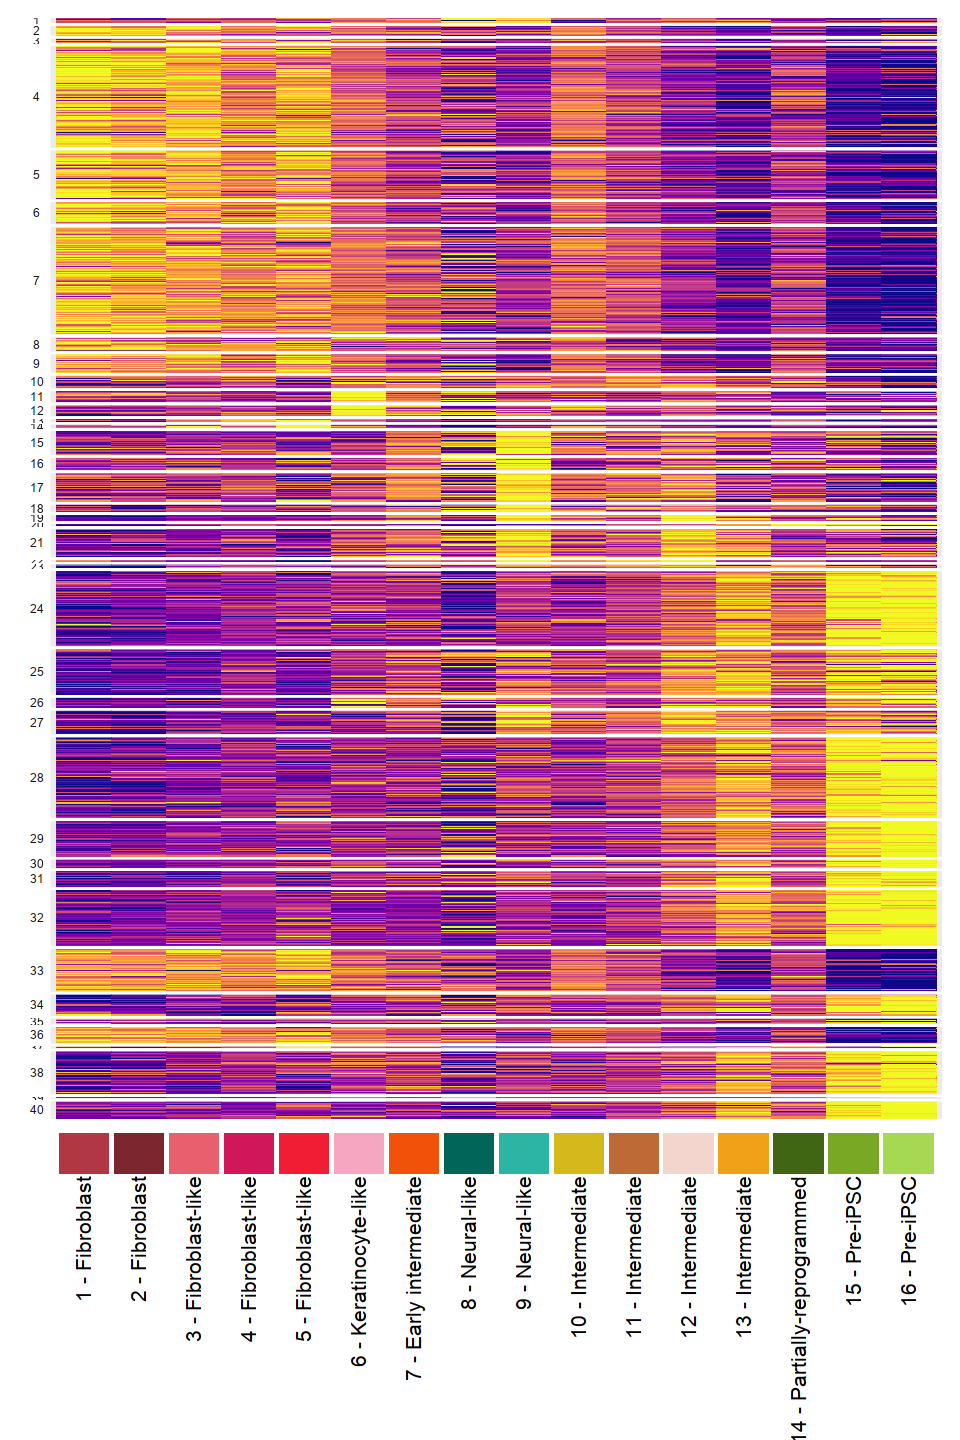

In [601]:
options(repr.plot.width = 8, repr.plot.height = 12)

p2g_heatmap_gene_with_colorbar = wrap_plots(heatmap_rna, cluster_colourbar, nrow=2, heights=c(10,0.4))
p2g_heatmap_gene_with_colorbar

### GO Terms

In [423]:
go_terms = read.table("./go.dummy.tsv", sep='\t', header=T)
levels(go_terms$term_name) = rev(go_terms$term_name)
go_terms$logpval = -log10(go_terms$p_value)
dim(head(go_terms))
head(go_terms)

[1] 6 4

term_name                                                p_value      group
1 vasculogenesis                                           1.272988e-03 1    
2 animal organ morphogenesis                               4.407436e-03 1    
3 positive regulation of metabolic process                 3.977601e-05 1    
4 bone morphogenesis                                       1.549097e-04 2    
5 positive regulation of supramolecular fiber organization 1.388842e-02 2    
6 anatomical structure formation involved in morphogenesis 2.837456e-02 2    
  logpval 
1 2.895176
2 2.355814
3 4.400379
4 3.809921
5 1.857347
6 1.547071

In [767]:
options(repr.plot.width = 7, repr.plot.height = 10)

go_plot = ggplot(data = go_terms, 
       aes(x = 0, y = term_name, fill = logpval)) +
geom_point(size=6, pch=21)  + ylab(NULL) + xlab(NULL) +  
facet_grid(group ~ ., switch = "y", scales = "free_y", space = "free_y")+
scale_fill_gradient(low="gray",
                      high="red",
                      limits=c(1, 5),
                      oob=squish,
                      name="- Log P-value") +
# theme_() +
scale_y_discrete(position="right") +
theme(axis.text.x = element_blank() , # element_text(angle = 90, hjust = 1),
        axis.text.y=element_text(size=14),
#         axis.ticks.y=element_blank(),
        axis.ticks.x=element_blank(),     
        strip.background = element_blank(),      
        strip.text.y.left = element_blank(), 
        panel.background = element_blank(),
        panel.spacing = unit(0.15, "lines"),
     legend.position = "none") 

In [768]:
options(repr.plot.width = 7, repr.plot.height = 10)

go_plot_legend = cowplot::get_legend(ggplot(data = go_terms, 
                   aes(x = 1, y = term_name, fill = logpval)) +
            geom_point(size=6, pch=21)  + ylab(NULL) + xlab(NULL) +  
            scale_fill_gradient(low="gray",
                                  high="red",
                                  limits=c(1, 5),
                                  oob=squish,
                                  name="- Log P-value ") +
            theme(legend.position = "bottom"))

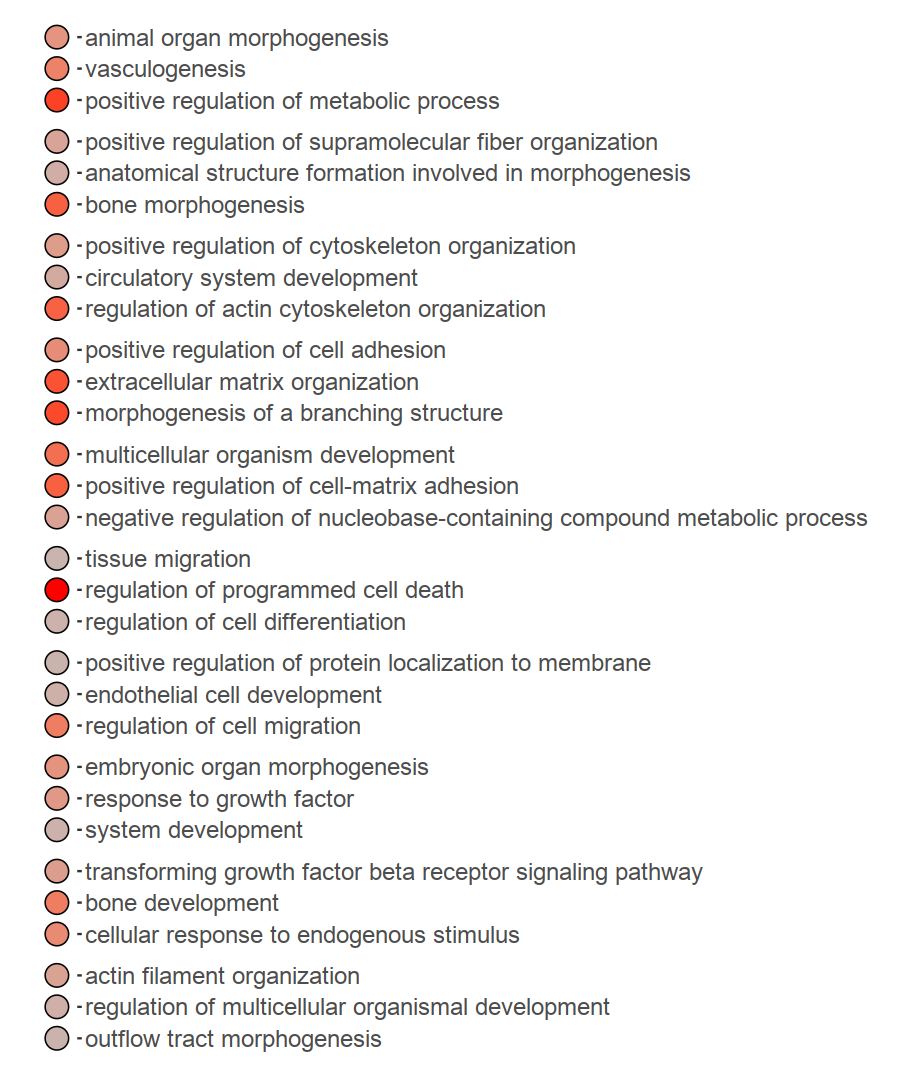

In [769]:
options(repr.plot.width = 7.6, repr.plot.height = 9)

wrap_plots(plot_spacer(), go_plot, plot_spacer(), widths=c(0,1,0))

### Connections Plot

In [679]:
# connect from gene heatmap to GO terms and add gene annotations
connections_plot = ggplot() + 
                theme_void() +
                geom_line() +
                coord_cartesian(xlim = c(0.5,9.5), # this let's use 0-10 on x axis to place items
                               ylim=c(1,21)) + # this let's use 0-22 on y axis to place items
                annotate("segment", x = 0, xend = 10, y = 21.5, yend = 21.5, size=0.5, linetype="dashed", colour = "black") +
                annotate("text", x = 5, y = 21, size=5, label = "GENE1") +
                annotate("text", x = 5, y = 20, size=5, label = "GENE2") +
                annotate("text", x = 5, y = 19, size=5, label = "GENE3") +
                annotate("text", x = 5, y = 18, size=5, label = "GENE4") +
                annotate("text", x = 5, y = 17, size=5, label = "GENE5") +

                annotate("segment", x = 0, xend = 10, y = 14, yend = 17.5, size=0.5, linetype="dashed", colour = "black") +
                annotate("text", x = 5, y = 14.5, size=5, label = "GENE6") +
                annotate("text", x = 5, y = 13.5, size=5, label = "GENE7") +

                annotate("segment", x = 0, xend = 10, y = 13, yend = 13, size=0.5, linetype="dashed", colour = "black") +
                annotate("text", x = 5, y = 12, size=5, label = "GENE8") +
                annotate("text", x = 5, y = 11, size=5, label = "GENE9") +

                annotate("segment", x = 0, xend = 10, y = 11, yend = 9, size=0.5, linetype="dashed", colour = "black") +
                annotate("text", x = 5, y = 9, size=5, label = "GENE10") +
                annotate("text", x = 5, y = 8, size=5, label = "GENE11") +
                annotate("text", x = 5, y = 7, size=5, label = "GENE12") +
                annotate("text", x = 5, y = 6, size=5, label = "GENE13") +
                annotate("text", x = 5, y = 5, size=5, label = "GENE14") +
                annotate("text", x = 5, y = 4, size=5, label = "GENE15") +
                annotate("text", x = 5, y = 3, size=5, label = "GENE16") +
                annotate("text", x = 5, y = 2, size=5, label = "GENE17") +
                annotate("text", x = 5, y = 1, size=5, label = "GENE18") +

                annotate("segment", x = 0, xend = 10, y = 0.5, yend = 0.5, size=0.5, linetype="dashed", colour = "black")  

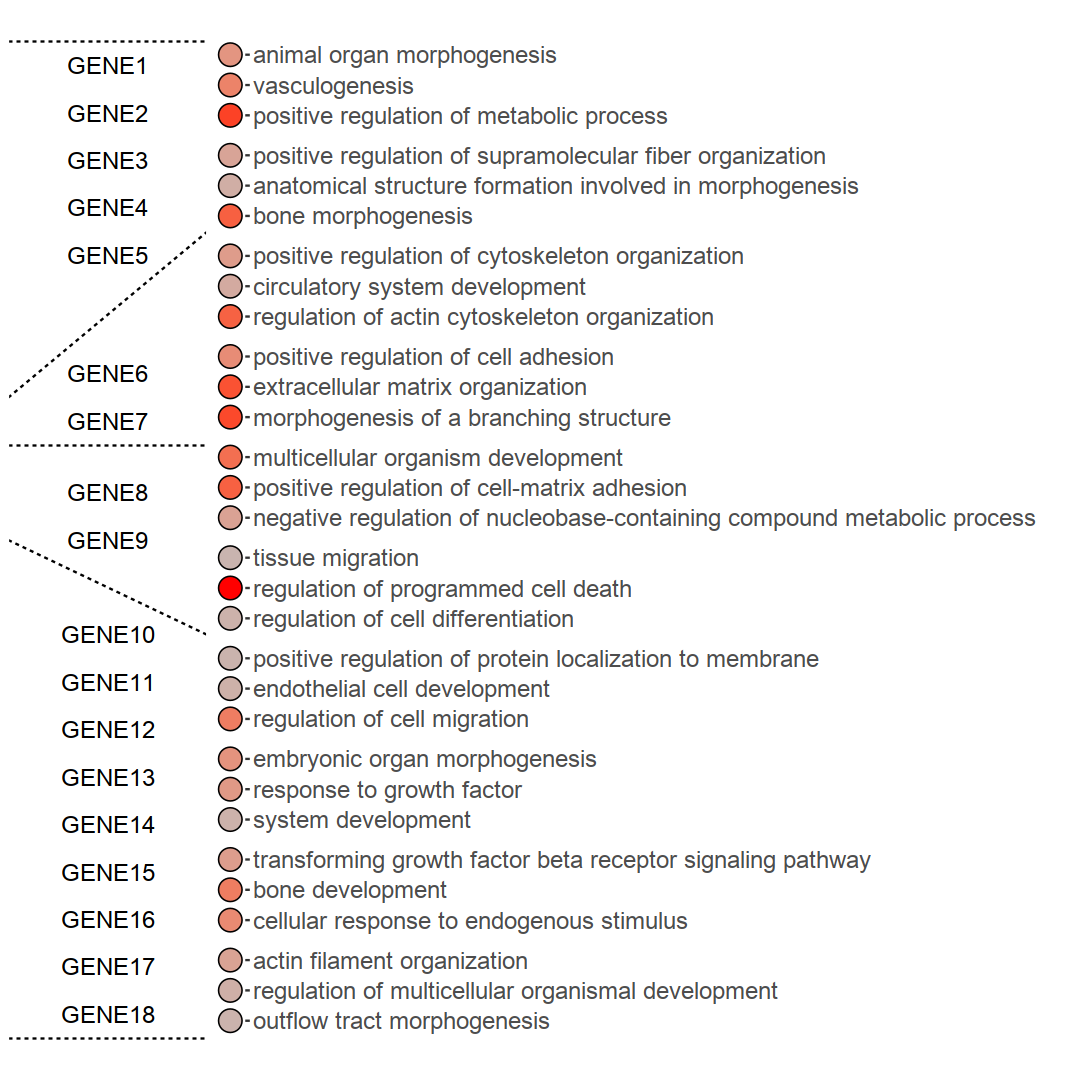

In [687]:
options(repr.plot.width = 9, repr.plot.height = 9)

wrap_plots(connections_plot,
           wrap_plots(ver_spacer(go_plot), plot_spacer(), widths=c(1,0)),
#            ver_spacer(hor_spacer(go_plot)),
           widths=c(1.7,7.3))

### Side-by-side

In [455]:
hor_spacer <- function(inplot) {
    wrap_plots(plot_spacer(),
              inplot,
              plot_spacer(),
              widths=c(0,1,0))
}

ver_spacer <- function(inplot) {
    wrap_plots(plot_spacer(),
              inplot,
              plot_spacer(),
              heights=c(0,1,0))
}

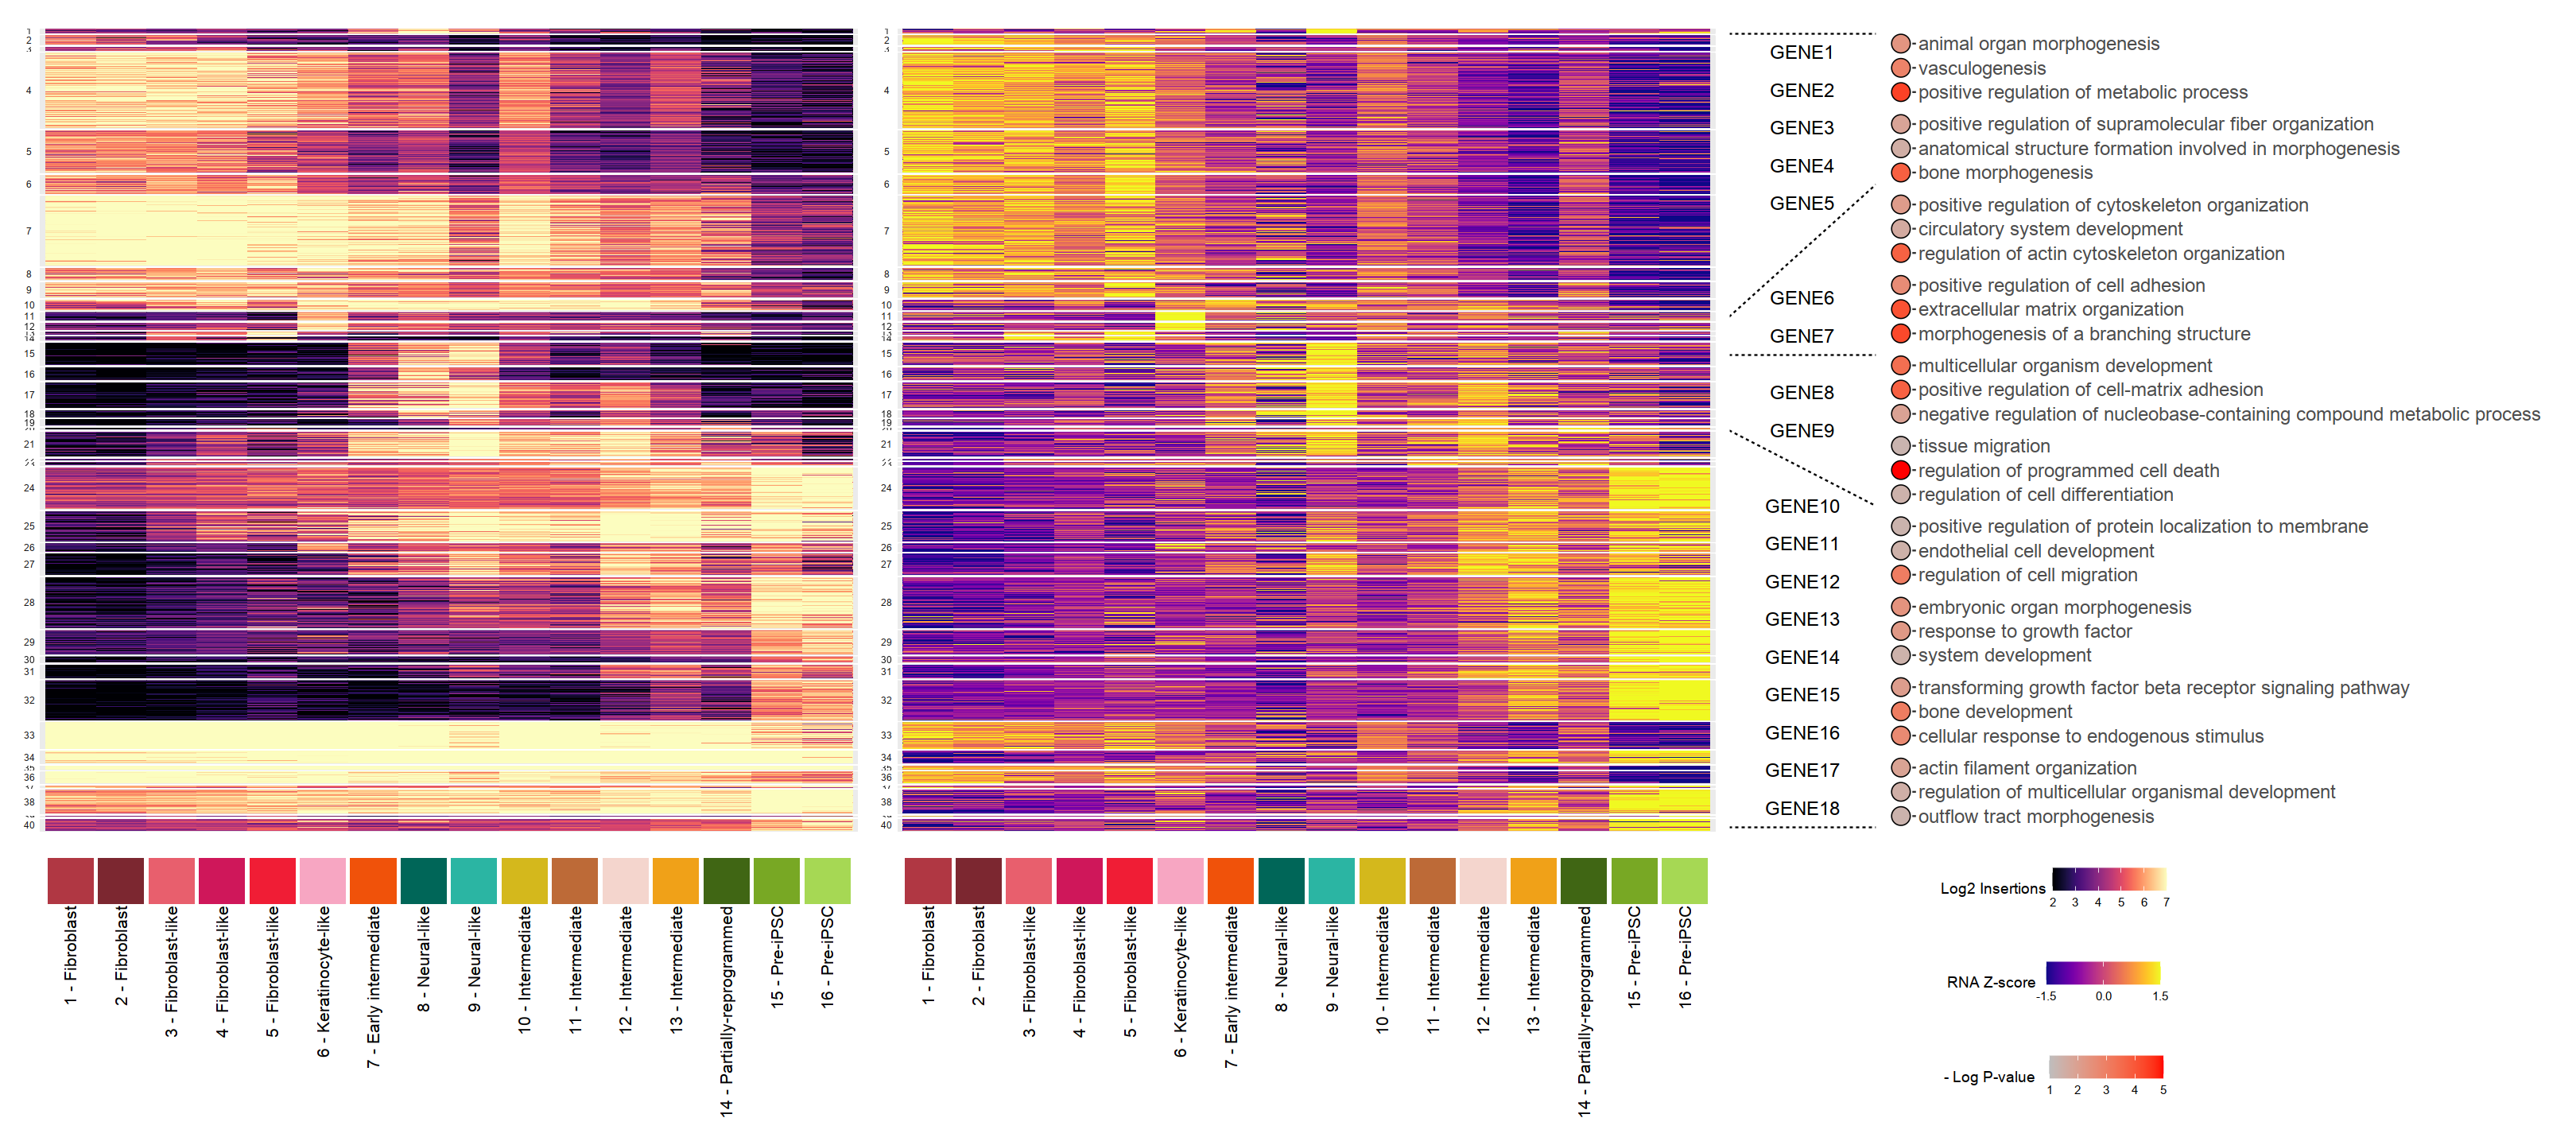

In [703]:
options(repr.plot.width = 27, repr.plot.height = 12)

padded_colorbar = ver_spacer(cluster_colourbar)

peak_w_cbar = ver_spacer(wrap_plots(heatmap_peaks,
                        padded_colorbar,
                        heights=c(9,3)))

gene_w_cbar = ver_spacer(wrap_plots(heatmap_rna,
                        padded_colorbar,
                        heights=c(9,3)))

legends_plot = wrap_plots(heatmap_peaks_legend,
                         heatmap_rna_legend,
                         go_plot_legend,
                         heights=c(1,1,1))

connections_plot_w_spacer = wrap_plots(connections_plot,
                                      plot_spacer(),
                                      heights=c(9,3))

go_w_legends = ver_spacer(wrap_plots(wrap_plots(go_plot, plot_spacer(), widths=c(1,0)),
                                  wrap_plots(
                                      legends_plot,
                                      plot_spacer(),
                                      widths = c(1,1)),
                                  heights=c(9,3)))

p2g_go = wrap_plots(peak_w_cbar,
           gene_w_cbar, 
           connections_plot_w_spacer,
           go_w_legends,
           widths=c(9, 9, 1.6, 7.4))

p2g_go

In [779]:
saveRDS(p2g_go, file=sprintf("./subfigs/%s_peak_to_gene_GO.rds",
                            format(Sys.Date(), "%Y%m%d")))
saveRDS(peak_assignments_with_link, file=sprintf("./subfigs/%s_peak_assignments_with_link.rds",
                            format(Sys.Date(), "%Y%m%d")))

## Gridmaps

In [708]:
NROW=4
NCOL=5
ORDER = c("idx2", "idx3", "idx4", "idx5", "idx6", 
          "idx8", "idx9", "idx10", "idx11", "idx12",
          "idx13", "idx14", "idx15", "idx16", "idx17",
          "idx21", "idx25", "idx28", "idx32", "idx34")

stopifnot(length(ORDER)==NROW*NCOL)

In [709]:
peak_regions_str = as.character(peak_regions_gr)

In [792]:
plots = list()
for (i in seq(NROW*NCOL)) {
    matrix_peaks_in_peak_set = (peak_regions_str %in% rownames(binnorm_log_cts)[peak_to_row_idx==ORDER[i]])
    
    norm_reads_in_region = Matrix::rowSums(pmat[, matrix_peaks_in_peak_set])/pmatRowSums
    
    df = data.frame(umap1=metaData$umap1, 
                    umap2=metaData$umap2,
                    percent_reads=100*norm_reads_in_region)
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1], 30000), ]

    plots[[i]] = ggplot(df) +
    # ggplot(df[df$percent_reads<2, ]) +
    geom_point(size=0.3, stroke = 0, alpha=1, aes(x=umap1 , y=umap2, col=percent_reads)) +
    ggtitle(sprintf("P%s (%d peaks)",  
                    old_to_new_peak_set_idx_map[[ORDER[i]]], # mapping to order in above heatmap
                    sum(matrix_peaks_in_peak_set))) + 
    xlab("UMAP 1") + ylab("UMAP 2") +
    
    scale_color_viridis_c(limits= c(0, 
                                  quantile(100*norm_reads_in_region, 0.99)), 
                          oob=squish, option = "B",
                          # Integer breaks only: https://stackoverflow.com/a/39877048/2948201
                          breaks = function(x) unique(floor(pretty(seq(0, (max(x) + 1) * 1.1)))),
                         name='Normalized\nInsertions') +
                          
    theme_classic() +
    theme(
         #plot.title = element_text(hjust = 0.5),
         plot.title = element_text(hjust=0.05, size=12,
                                   margin = margin(b = -20)),
         axis.ticks = element_blank(),
         axis.text = element_blank(),
         axis.title = element_blank(),
         legend.title = element_blank(),
#          legend.text = element_blank(), # no numbers
         legend.background = element_blank(), # strip whitespace around colorbar
         legend.key.size = unit(0.15, "inches"),
         legend.position = c(0.08, 0.18), 
         panel.border = element_rect(colour = "black", fill=NA, size=0.5)) + 
    coord_fixed()
}

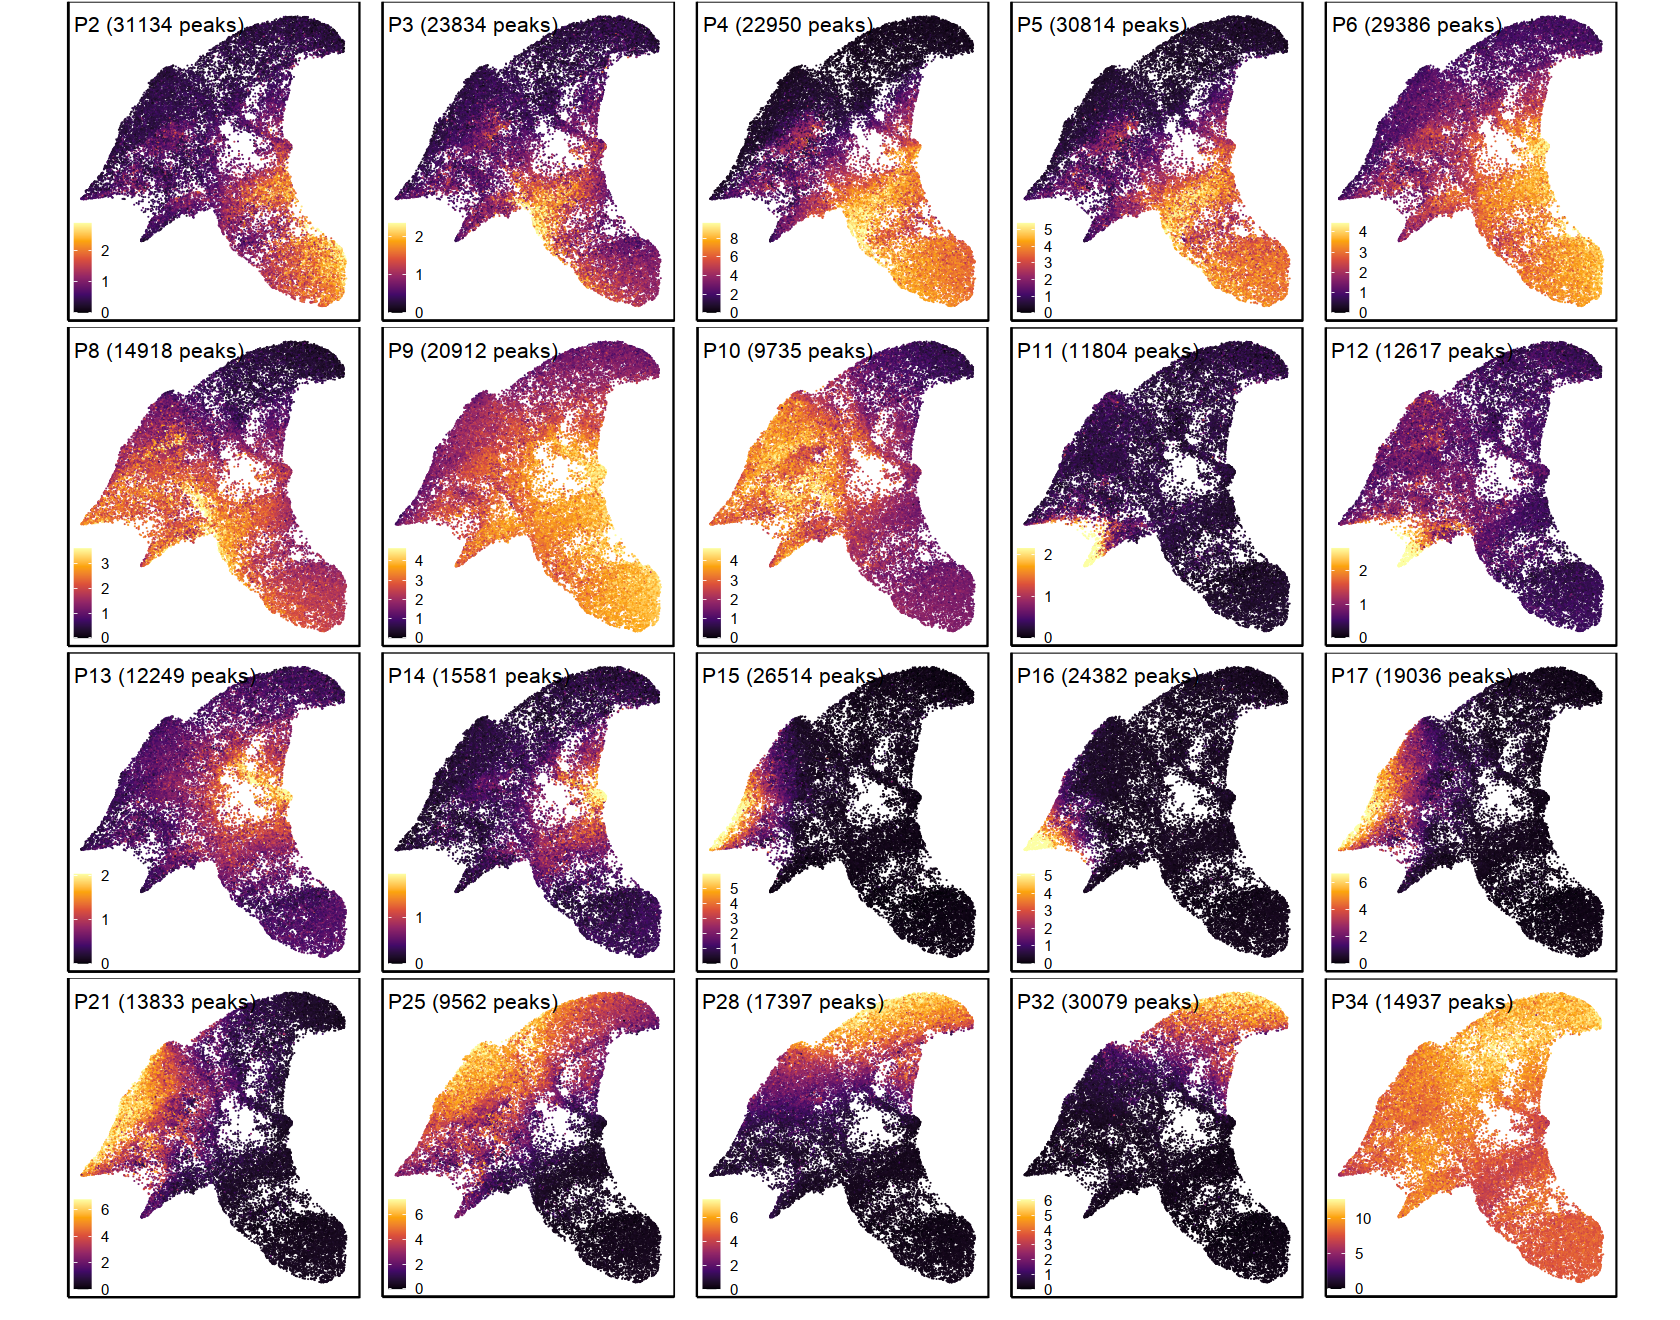

In [793]:
options(repr.plot.width = 14, repr.plot.height = 11)
gridmap = wrap_plots(plots, ncol = NCOL) 

gridmap 

In [746]:
saveRDS(gridmap, file=sprintf("./subfigs/%s_gridmap.rds",
                            format(Sys.Date(), "%Y%m%d")))

### Heatmap with Gridmap

In [77]:
vertical_spacers <- function(plot, heights=c(0,1,0)) {
    wrap_plots(plot_spacer(), plot, plot_spacer(), ncol=1, heights=heights)
}

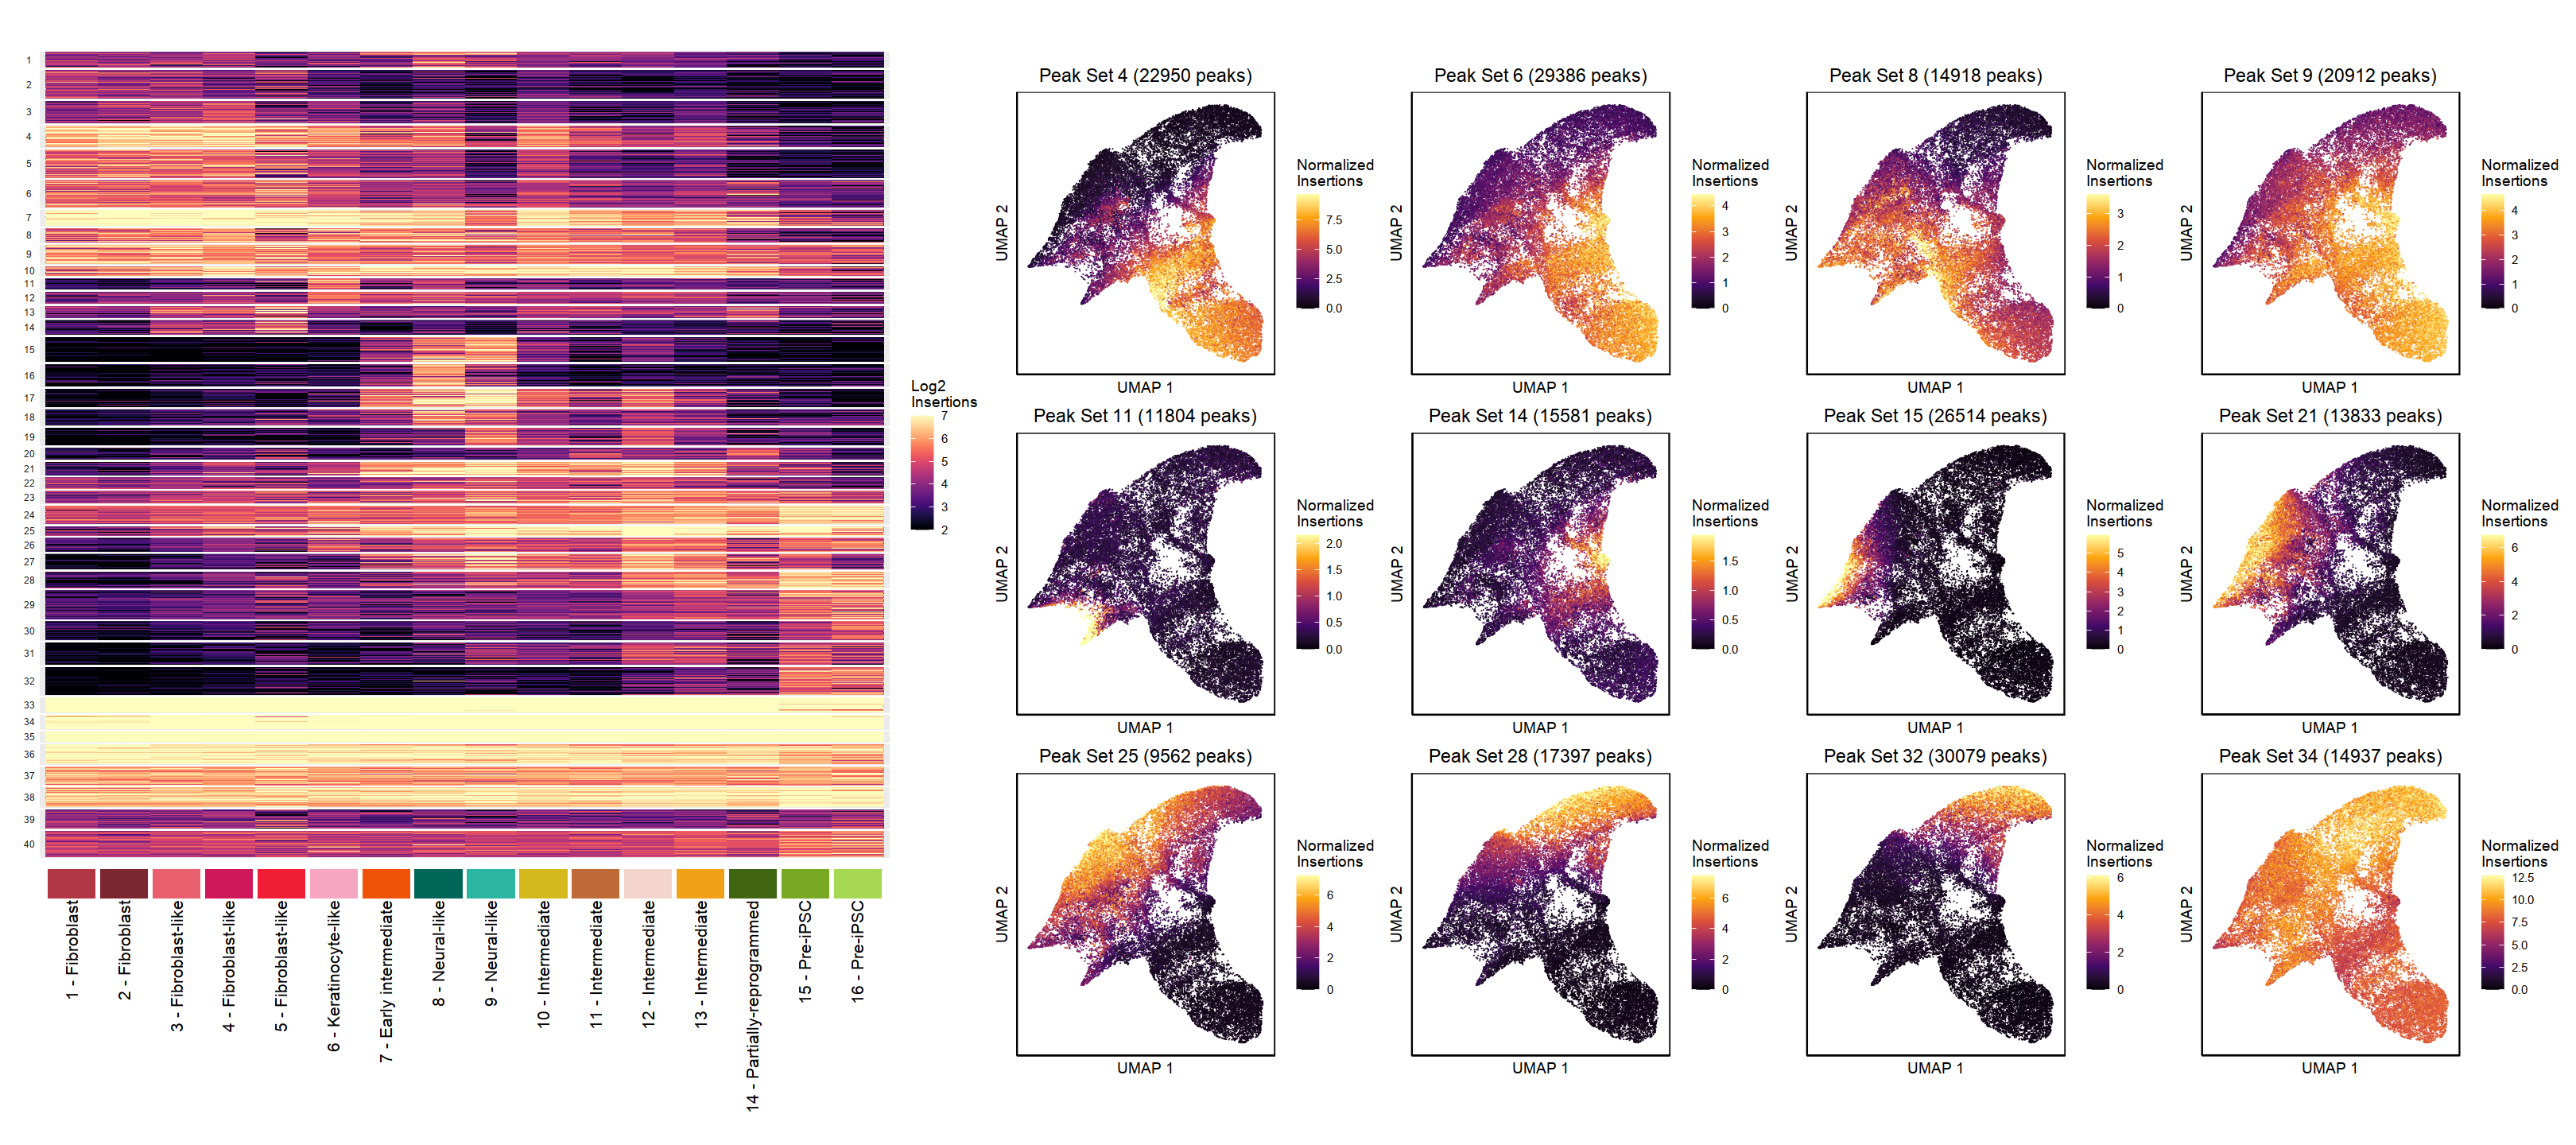

In [78]:
# together
options(repr.plot.width = 27, repr.plot.height = 12)

wrap_plots(vertical_spacers(cluster_by_day_with_colourbar),
           wrap_plots(plots, ncol = NCOL),
           widths=c(10,17))